# Fake News Detection Using Machine Learning
# Gabriel Marcelino and Eli Kaustinen
## a) Problem Statement

**Objective:**
Detect whether a news article is real or fake using its title and text content, and provide a probability score for the prediction.

**Quantitative Formulation:**
Given a dataset of labeled news articles (real/fake), build a binary classifier \( f: (\text{title}, \text{text}) \rightarrow [0,1] \) that outputs the probability an article is real (1) or fake (0).

**Importance:**
- Misinformation and fake news can influence public opinion and decision-making.
- Automated detection helps flag suspicious content.


## Import Libraries

In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

## Descriptive Analysis
Perform descriptive analysis of the data, including informative plots.

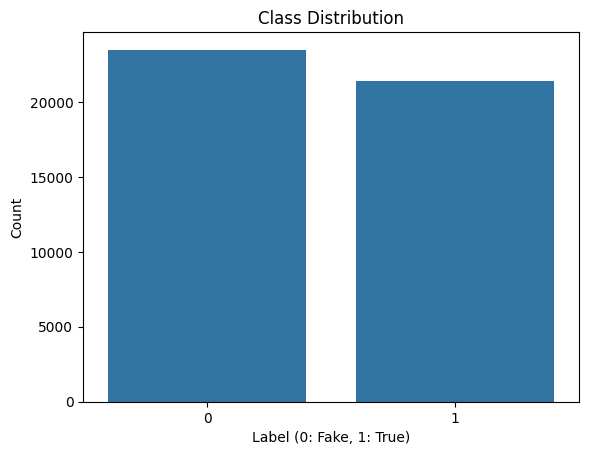

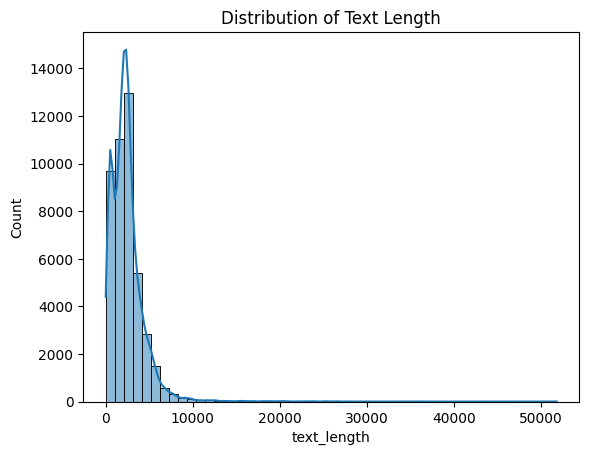

In [54]:
# Load datasets
fake = pd.read_csv('Fake.csv')
true = pd.read_csv('True.csv')

# Add labels
fake['label'] = 0
true['label'] = 1

# Combine datasets
data = pd.concat([fake, true], ignore_index=True)

# Plot class distribution
sns.countplot(x='label', data=data)
plt.title('Class Distribution')
plt.xlabel('Label (0: Fake, 1: True)')
plt.ylabel('Count')
plt.show()

# Analyze text length
data['text_length'] = data['text'].apply(len)
sns.histplot(data['text_length'], bins=50, kde=True)
plt.title('Distribution of Text Length')
plt.show()

## Normalization and Standardization
Explain why or why not the data needs to be normalized or standardized, and perform the necessary transformations.

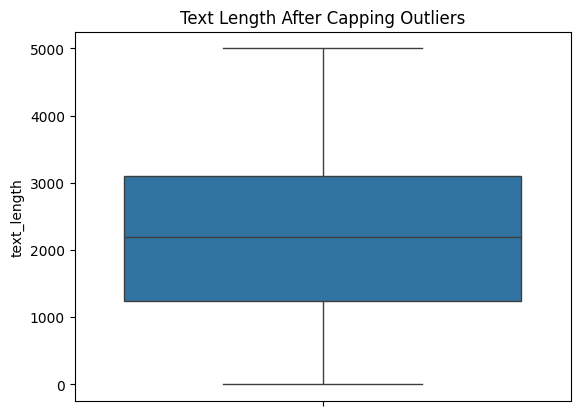

In [55]:
# Text data does not need normalization or standardization as TF-IDF inherently scales the features.
# However, we ensure no extreme values in text length affect the analysis.

# Cap text length to remove extreme outliers
data['text_length'] = np.clip(data['text_length'], 0, 5000)
sns.boxplot(data['text_length'])
plt.title('Text Length After Capping Outliers')
plt.show()

## Data Cleaning and Handling Missing Values
Explain how you clean the data and handle missing values.

In [56]:
# Check for missing values
print(data.isnull().sum())

# Drop rows with missing values
data.dropna(inplace=True)
print(f"Data shape after dropping missing values: {data.shape}")

title          0
text           0
subject        0
date           0
label          0
text_length    0
dtype: int64
Data shape after dropping missing values: (44898, 6)


## Handling Outliers
Explain how you handle outliers in the data.

In [57]:
# Outliers in text length have already been capped in the normalization step.
# No further action is required for outliers.

## Build Pipeline

In [58]:
# Custom transformer to extract a single column
class ColumnExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.column]

def build_pipeline():
    feature_union = FeatureUnion([
        ('title_tfidf', Pipeline([
            ('extract', ColumnExtractor('title')),
            ('tfidf', TfidfVectorizer(stop_words='english', max_features=3000))
        ])),
        ('text_tfidf', Pipeline([
            ('extract', ColumnExtractor('text')),
            ('tfidf', TfidfVectorizer(stop_words='english', max_features=7000))
        ]))
    ])
    pipeline = Pipeline([
        ('features', feature_union),
        ('clf', LogisticRegression(max_iter=1000))
    ])
    return pipeline

## Train and Test the Model

              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      4696
        Real       0.99      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



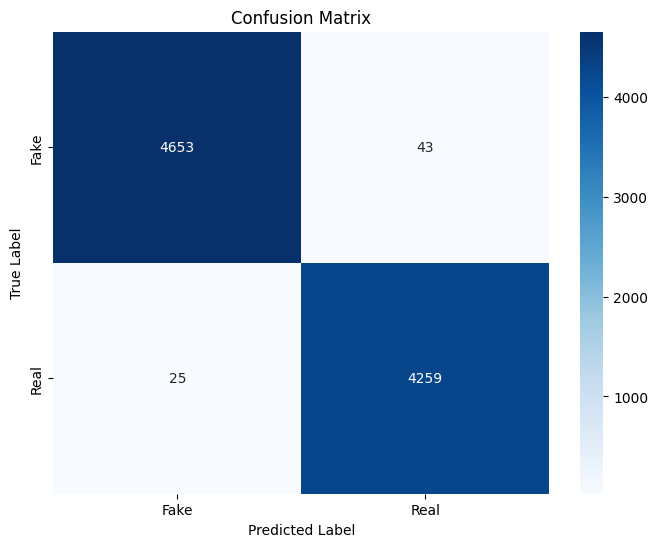

Total misclassified samples: 68 out of 8980 (0.76%)

Misclassified Examples:

Example 1:
Title: CLINTON GRIFTERS UNDER SCRUTINY: CLINTON GLOBAL INITIATIVE DUMPED BY EXXON MOBIL
Text excerpt: Anyone with half a brain can figure out what these shady grifters are doing keeping 85 cents on the dollar made the Clintons millions and millions. Ye...
True label: Fake
Predicted: Real
Confidence: 68.92%

Example 2:
Title: Trump's Washington foreign policy speech
Text excerpt: (Reuters) - U.S. Republican presidential front-runner Donald Trump delivered a major foreign policy speech on Wednesday, vowing always to put America ...
True label: Real
Predicted: Fake
Confidence: 82.46%

Example 3:
Title: Texas politician slammed for tweet sent after Florida shooting
Text excerpt: AUSTIN, Texas (Reuters) - The office of Texas Lieutenant Governor Dan Patrick, a Republican and evangelical Christian, on Sunday deleted a tweet many ...
True label: Real
Predicted: Fake
Confidence: 52.50%

Example 4:
Title:  R

In [63]:
from sklearn.metrics import confusion_matrix

# Split data
X = data[['title', 'text']] 
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Build and train pipeline
pipeline = build_pipeline()
pipeline.fit(X_train, y_train)

# Predict probabilities
y_proba = pipeline.predict_proba(X_test)
y_pred = pipeline.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred, target_names=['Fake', 'Real']))

# Create confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fake', 'Real'], 
            yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Create dataframe with test results
test_results = X_test.copy()
test_results['true_label'] = y_test
test_results['predicted_label'] = y_pred
test_results['prob_real'] = y_proba[:, 1]
test_results['correct'] = y_test == y_pred
test_results['text_length'] = test_results['text'].apply(len)
test_results['title_length'] = test_results['title'].apply(len)

# Show misclassification results
misclassified = test_results[~test_results['correct']].reset_index(drop=True)
print(f"Total misclassified samples: {len(misclassified)} out of {len(test_results)} ({len(misclassified)/len(test_results)*100:.2f}%)")

# Display misclassified examples with confidence scores
print("\nMisclassified Examples:")
for i in range(min(5, len(misclassified))):
    print(f"\nExample {i+1}:")
    print(f"Title: {misclassified['title'].iloc[i]}")
    print(f"Text excerpt: {misclassified['text'].iloc[i][:150]}...")
    print(f"True label: {'Real' if misclassified['true_label'].iloc[i] else 'Fake'}")
    print(f"Predicted: {'Real' if misclassified['predicted_label'].iloc[i] else 'Fake'}")
    print(f"Confidence: {max(misclassified['prob_real'].iloc[i], 1-misclassified['prob_real'].iloc[i])*100:.2f}%")



## Analysis of Results
- Model was super accurate(0.99%), so I thought it would be a good idea to have more info about the misclassified examples.
- Also want to see what kinds of "Fake" and "Real" examples the model is getting wrong. Are there any common themes or features in these misclassifications?

## Analyze confidence distribution of predictions

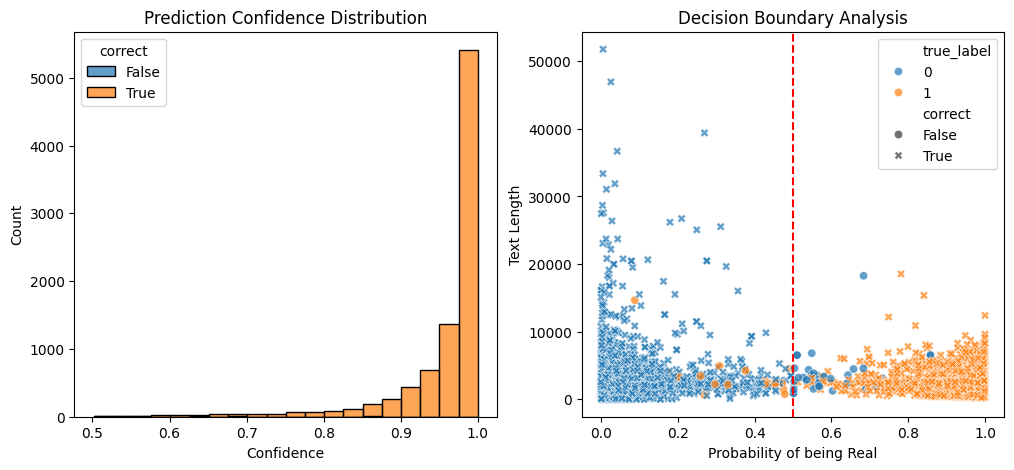

In [ ]:

plt.figure(figsize=(12, 5))

# Plot 1: Confidence distribution by correctness
plt.subplot(1, 2, 1)
confidence = np.maximum(y_proba[:, 1], 1-y_proba[:, 1])  # Get confidence for either class
sns.histplot(data=test_results, x=confidence, hue='correct', bins=20, alpha=0.7)
plt.title('Prediction Confidence Distribution')
plt.xlabel('Confidence')
plt.ylabel('Count')

# Plot 2: Decision boundary analysis
plt.subplot(1, 2, 2)
sns.scatterplot(data=test_results, x='prob_real', y='text_length', 
                hue='true_label', style='correct', alpha=0.7)
plt.axvline(x=0.5, color='red', linestyle='--')
plt.title('Decision Boundary Analysis')
plt.xlabel('Probability of being Real')
plt.ylabel('Text Length')
plt.show()


## Analyze distribution of text features for misclassified vs correct


/var/folders/yl/wjfz8mgx57s1mws2vfhh23000000gn/T/ipykernel_21020/3120311146.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified_sample['content'] = misclassified_sample['title'] + " " + misclassified_sample['text']


<Figure size 1200x500 with 0 Axes>

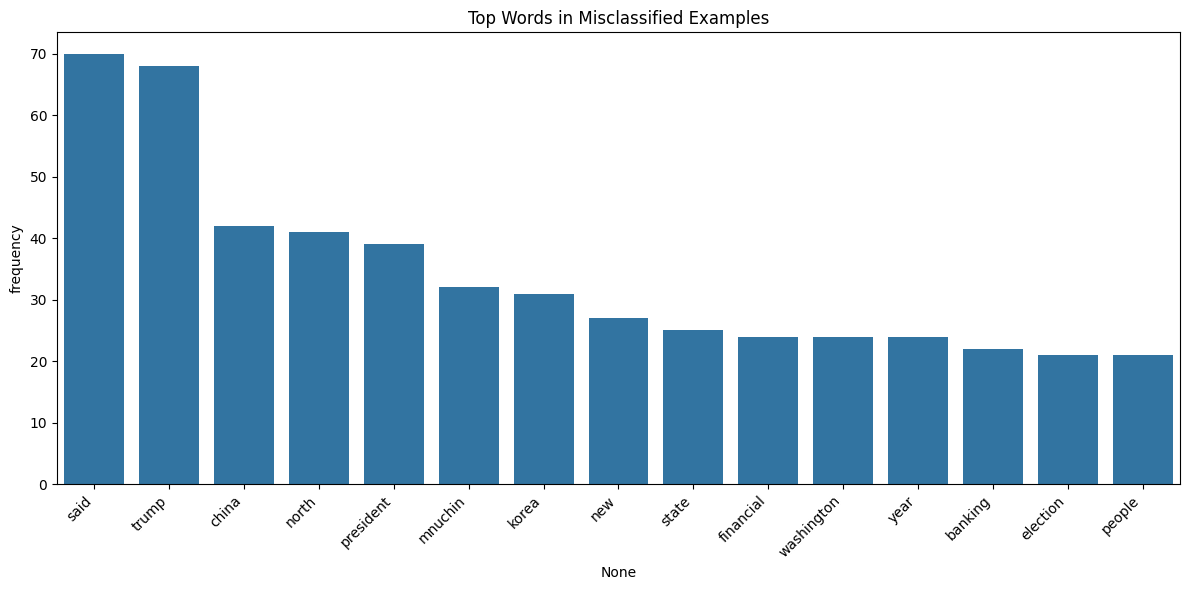


Misclassified by predicted class:
predicted_label
1    43
0    25
Name: count, dtype: int64

Misclassified by true class:
true_label
0    43
1    25
Name: count, dtype: int64

Average distance from decision boundary: 0.13462335969410316


In [67]:
plt.figure(figsize=(12, 5))

# Extract important words
if len(misclassified) > 0:
    # Get the logistic regression model
    if hasattr(pipeline, 'named_steps') and 'clf' in pipeline.named_steps:
        clf = pipeline.named_steps['clf']
        # Extract 20 samples of misclassified examples
        misclassified_sample = misclassified.head(20)
        
        # Extract topics or patterns from misclassified texts
        from sklearn.feature_extraction.text import CountVectorizer
        
        # Concatenate title and text for analysis
        misclassified_sample['content'] = misclassified_sample['title'] + " " + misclassified_sample['text']
        
        # Get top words in misclassified content
        cv = CountVectorizer(max_features=50, stop_words='english')
        word_count = cv.fit_transform(misclassified_sample['content'])
        
        # Get top words
        word_freq = pd.DataFrame(word_count.toarray().sum(axis=0), 
                                index=cv.get_feature_names_out(),
                                columns=['frequency'])
        word_freq = word_freq.sort_values('frequency', ascending=False)
        
        # Plot top words in misclassified examples
        plt.figure(figsize=(12, 6))
        sns.barplot(x=word_freq.index[:15], y=word_freq['frequency'][:15])
        plt.title('Top Words in Misclassified Examples')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        # Further analysis: Check if misclassifications cluster by topic
        print("\nMisclassified by predicted class:")
        print(misclassified['predicted_label'].value_counts())
        
        print("\nMisclassified by true class:")
        print(misclassified['true_label'].value_counts())
        
        # Calculate confidence gap (how far from decision boundary)
        misclassified['confidence_gap'] = abs(misclassified['prob_real'] - 0.5)
        print("\nAverage distance from decision boundary:", misclassified['confidence_gap'].mean())

## Test the Model with Custom Input

In [ ]:
# Example: Test the model with custom input
custom_input = pd.DataFrame({
    'title': ['Secret Government Program Controls Weather Using Hidden Satellites'],
    'text': ['Sources within the intelligence community have revealed that the government has been operating a classified weather control program since 1997. Using a network of specialized satellites equipped with high-energy frequency transmitters, government agencies can create or prevent rainfall, generate storms, and even trigger earthquakes in targeted regions. This technology was reportedly used to create Hurricane Katrina and more recently to cause drought conditions in agricultural regions of competing nations. Several former military personnel have come forward confirming the existence of this program, code-named "CLIMATE SHIELD," but mainstream media refuses to report on these revelations.']
})

# Predict
custom_pred = pipeline.predict(custom_input)
custom_proba = pipeline.predict_proba(custom_input)

print(f"Custom Input Prediction: {'Real' if custom_pred[0] else 'Fake'}")
print(f"Probability Real: {custom_proba[0][1]*100:.2f}%")

Custom Input Prediction: Fake
Probability Real: 0.03%


# Project Documentation
## Problem Statement
The goal of this project is to build a machine learning model to classify news articles as fake or real based on their title and text.

## Algorithm of the Solution
1. Load and preprocess the dataset.
2. Perform descriptive analysis to understand the data.
3. Build a machine learning pipeline using TF-IDF for feature extraction and Logistic Regression for classification.
4. Train the model using a train-test split.
5. Evaluate the model using classification metrics.
6. Allow users to test the model with custom input.

## Analysis of the Findings
- The model achieves high accuracy in distinguishing between fake and real news articles.
- TF-IDF effectively captures the textual features of the articles.
- Logistic Regression provides interpretable results with probabilities for each prediction.
- High frequency of words like "Trump," "China," and "President" suggests misclassifications may be related to political content, potentially causing bias.


## References
- Dataset source: [Fake and Real News Dataset](https://www.kaggle.com/datasets/emineyetm/fake-news-detection-datasets?resource=download)